# About

Comparing theoretical analysis with numeric results in a simplified 2-dimensional Kuramoto system with adaptive delays and no
self-feedback interactions.

# Library

In [1]:
from __future__ import division, print_function

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt
import math
from math import pi

from lib import *

from IPython.display import clear_output
%matplotlib inline

# Directories

In [2]:
# Data files
name_folder = 'matlab2D_1'
name_file = 'gain_30_num_1'

# Directory
dir_main = os.getcwd()
dir_folder = os.path.join(dir_main, 'data', name_folder)
dir_mat = os.path.join(dir_folder, name_file)

# Import using Scipy
dict_mat = sio.loadmat(dir_mat)

# Import Data

In [3]:
# Solution
sol = {}
sol['t'] = np.reshape(dict_mat['t'], -1)
sol['y'] = dict_mat['y']
sol['yp'] = dict_mat['yp']

sol['tau'] = dict_mat['tau']
sol['taup'] = dict_mat['taup']

# Parameters
sol['g'] = dict_mat['g'][0,0]
sol['omega0'] = dict_mat['omega0'][0,0]
sol['Delta0'] = dict_mat['Delta0'][0,0]

sol['gain'] = dict_mat['gain'][0,0]
sol['tau0'] = np.reshape(dict_mat['tau0'], -1)

sol['tf'] = dict_mat['tf'][0,0]

# Processing


## Numerical Results

In [4]:
# Asymptotic percentage
asy = 0.1

# Compute the global frequency:
arr_omega = asylib.weight_avg(sol['t'], sol['yp'], asy)
Omega = np.sum(arr_omega) / arr_omega.size

Omega_vars = asylib.weight_avg(sol['t'], (sol['yp'] - Omega)**2, asy)
Omega_var = np.sum(Omega_vars)

# Get array of asymptotic phases:
arr_lin = Omega*sol['t']
arr_lin = arr_lin[:,None]

arr_phases = sol['y'] - arr_lin
asy_phases = asylib.weight_avg(sol['t'], arr_phases, asy)

# Variance
phase_vars = asylib.weight_avg(sol['t'], (arr_phases - asy_phases)**2, asy)
phase_var = np.sum(phase_vars)

## Numerical Results (graph)

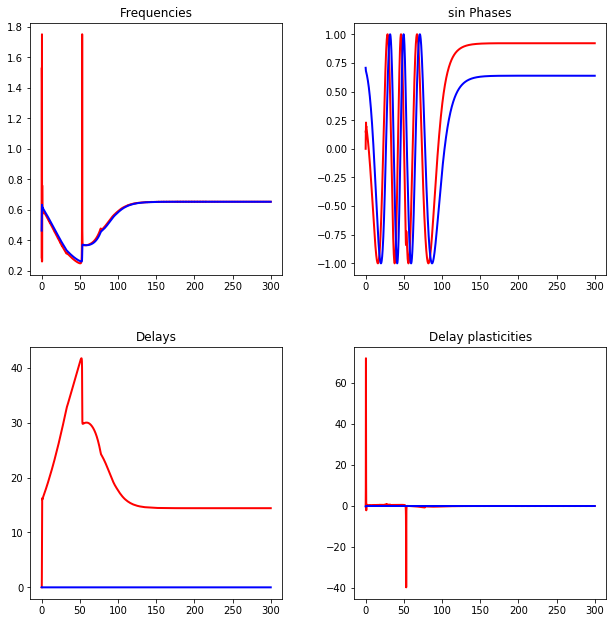

In [5]:
# Configure plots
fig, ax = plt.subplots(4, figsize=(10,10))

# [left, bottom, width, height] 
bbox0 = [0.1, 0.1, 0.35, 0.35]
bbox1 = [0.55, 0.1, 0.35, 0.35]
bbox2 = [0.1, 0.55, 0.35, 0.35]
bbox3 = [0.55, 0.55, 0.35, 0.35]

# Set ax positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)

# Titles
ax[0].set_title('Delays')
ax[1].set_title('Delay plasticities')
ax[2].set_title('Frequencies')
ax[3].set_title('sin Phases')

# Figure options
pltopts = {'linewidth': 2.0,
           'alpha': 1.0,
          }

ax[0].plot(sol['t'], sol['tau'], **pltopts)
ax[1].plot(sol['t'], sol['taup'], **pltopts)
ax[2].plot(sol['t'], sol['yp'], **pltopts)
ax[3].plot(sol['t'], np.sin(arr_phases), **pltopts)

# Set colours
for i in range(len(ax)):
    ax[i].lines[0].set_color('red')
    ax[i].lines[1].set_color('blue')

## Theoretical Analysis

In [6]:
# Fixed-point function
Omega_fun = lambda Omega: funlib.Omega2D(Omega, sol['tau0'], sol)[0]
Delta_fun = lambda Omega: funlib.Omega2D(Omega, sol['tau0'], sol)[1]

# Obtain fixed-points
w0 = sol['omega0']
g = sol['g']
Delta0 = sol['Delta0']

root_fun = lambda u: funlib.Omega2D_root(u, sol['tau0'], sol)
root_init = np.array([w0, Delta0])
root = optimize.root(root_fun, root_init, method='lm')

## Theoretical Analysis (Plot)

In [ ]:
# Plot 3D graph of root_fun


In [10]:
Delta1 = asy_phases[1] - asy_phases[0]
print(root.x, root.success, Omega, Delta0, Delta1)

[0.36228159 2.1250543 ] True 0.6532962737493218 0.7853981633974483 0.4805434345598627


In [8]:
print(root_fun(np.array([Omega, Delta1])))

[ 7.72085839e-05 -7.87798069e-06]
